In [1171]:
import numpy as np
import matplotlib.pyplot as plt

Assume Uniform Linear Array (ULA) w/ d = $\lambda/2$ 

Global constanants

In [1172]:
sample_rate = 1e6 
N = 300 # number of observations
d= 0.5 # Half Wavelengh 
Nr = 8 # Number of sensors
t = np.arange(N)/sample_rate # time vector

Define signal coming with given angular degree, amplitude and frequency

In [1173]:
def create_signal(theta_deg, amplitude, f_tone):
    x = (amplitude)*np.exp(2j * np.pi * f_tone * t)
    s = np.exp(-2j * np.pi * d * np.arange (Nr) * np.sin(theta_deg/180*np.pi))
    s = s.reshape(-1, 1) #column vector
    x = x.reshape(1, -1) #row vector
    X = s @ x
    return X

Create "stimulus"

In [1174]:
f_tone = 0.02e6 #tone frequency
tx = 1*np.exp(2j * np.pi * f_tone * t)
tx2 = 2*np.exp(2j * np.pi * f_tone*2 * t)
theta_deg = 50 # direction of arrival 
theta_deg2 = 2 # direction of arrival 
theta_deg3 = -10 # direction of arrival 
X1 = create_signal(theta_deg, 1, 0.02e6 )
X2 = create_signal(theta_deg2, 1, 0.52e6 )
X3 = create_signal(theta_deg3, 1, 0.32e6 )

Sum signals with noise and each other, plot resulting spectrum

(8, 300)
(8, 300)
(300,)


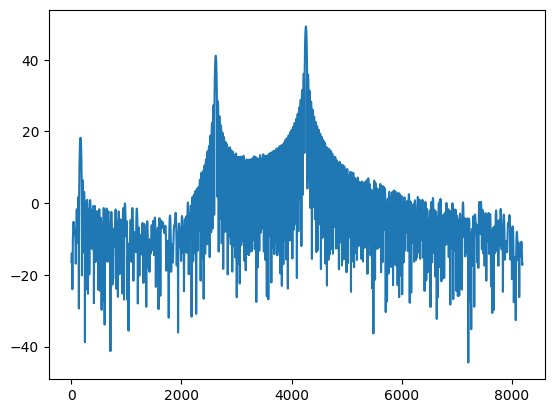

In [1175]:
n = np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)
print(np.shape(n))
X = X1 + X3 + X2 + 0.03*n  # X and n are both NrxN
print(X.shape)
Xsum = np.sum(X, 0)/Nr
print(Xsum.shape) # 3x10000.  X is now going to be a 2D array, 1D is time and 1D is the spatial dimension
plt.plot(10*np.log10(np.abs(np.fft.fft(Xsum, 8192))**2))
plt.show()

The MVDR/Capon beamformer can be summarized in the following equation:

$w_{mvdr} = \frac{R^{-1} s}{s^H R^{-1} s}$
where R is spatial covariance matrix i.e $R = XX^H$, and $s$ is steering vector (desired)

In [1176]:
# theta is the direction of interest, in radians, and X is our received signal
def w_mvdr(s):
   s = s.reshape(-1,1) # make into a column vector (size Nrx1)
   R = (X @ X.conj().T)/X.shape[1] # Calc covariance matrix. gives a Nr x Nr covariance matrix of the samples
   Rinv = np.linalg.pinv(R) # 3x3. pseudo-inverse tends to work better/faster than a true inverse
   w = (Rinv @ s)/(s.conj().T @ Rinv @ s) # MVDR/Capon equation! numerator is Nrx3 * Nrx1, denominator is 1xNr * NrxMr * Nrx1, resulting in a 3x1 weights vector
   return w

Perform MVDR for given steering vector 

In [1177]:
s = np.ones(Nr)
w = w_mvdr(s)
w = w.reshape(1, -1)
print(w)

[[ 0.98929357-0.59493403j  0.65961247-0.59802251j -0.48313939-0.21078902j
  -0.65203877+0.24104036j -0.56352008-0.07090332j -0.59669159+0.09436762j
   0.53581506+0.29134966j  1.11066872+0.84789124j]]


Plot polar coordinates

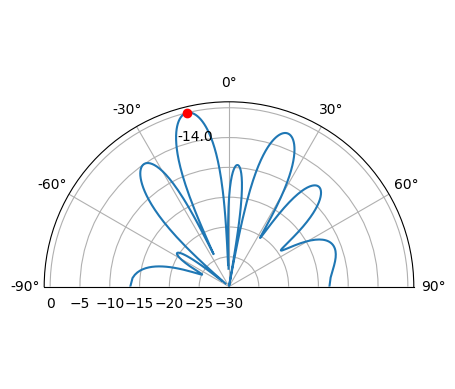

In [1178]:
N_fft = 512

w_padded = np.concatenate((w[0], np.zeros(N_fft - Nr))) # zero pad to N_fft elements to get more resolution in the FFT
w_fft_dB = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(w_padded)))**2) # magnitude of fft in dB
w_fft_dB -= np.max(w_fft_dB) # normalize to 0 dB at peak

# Map the FFT bins to angles in radians
theta_bins = np.arcsin(np.linspace(-1, 1, N_fft)) # in radians

# find max so we can add it to plot
theta_max = theta_bins[np.argmax(w_fft_dB)]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta_bins, w_fft_dB) # MAKE SURE TO USE RADIAN FOR POLAR
ax.plot([theta_max], [np.max(w_fft_dB)],'ro')
ax.text(theta_max - 0.1, np.max(w_fft_dB) - 4, np.round(theta_max * 180 / np.pi))
ax.set_theta_zero_location('N') # make 0 degrees point up
ax.set_theta_direction(-1) # increase clockwise
ax.set_rlabel_position(55)  # Move grid labels away from other labels
ax.set_thetamin(-90) # only show top half
ax.set_thetamax(90)
ax.set_ylim([-30, 1]) # because there's no noise, only go down 30 dB

plt.show()


Plot rectangular coordinates

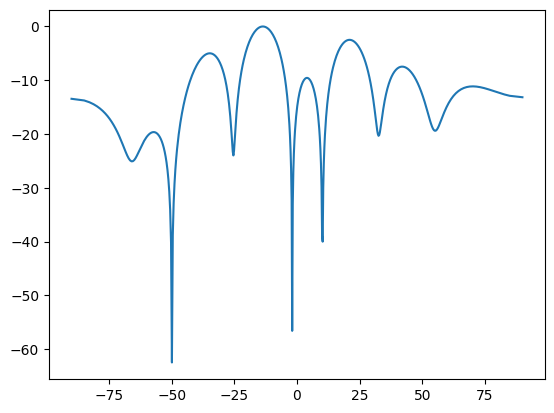

minimum zero of array @:  49.92179267246698
second minimum zero of array @:  1.9064736038888364
second minimum zero of array @:  50.271366440380156


In [1179]:
theta_scan = np.arcsin(np.linspace(-1, 1, N_fft))
plt.plot(theta_scan*180/np.pi, w_fft_dB)
plt.show()
print("minimum zero of array @: ", -theta_scan[np.argsort(w_fft_dB)[0]]*180/np.pi)
print("second minimum zero of array @: ", -theta_scan[np.argsort(w_fft_dB)[1]]*180/np.pi)
print("second minimum zero of array @: ", -theta_scan[np.argsort(w_fft_dB)[2]]*180/np.pi)

Now apply weigth vector to input array X and plot result

Shape of X: (8, 300)
Shape of w: (1, 8)
Shape of Y: (1, 300)


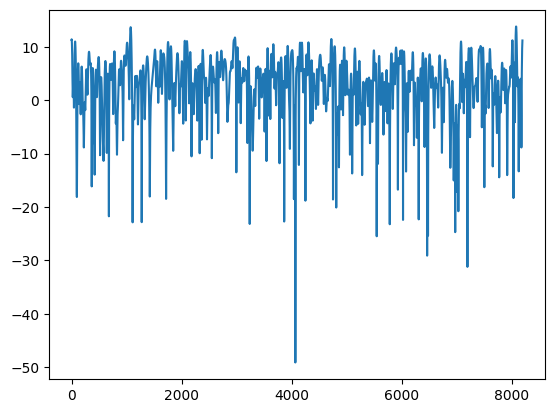

In [1180]:
print("Shape of X:", X.shape)
#w = w.reshape(-1, 1)
print("Shape of w:", w.shape)
Y = w @ X.conj() #instead w could be conjugated
print("Shape of Y:",Y.shape)
plt.plot(10*np.log10(np.abs(np.fft.fft(Y[0],8192))**2))
plt.show()